In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel

from SGDRegressor import SGDRegressor


%matplotlib inline

In [2]:

def load_data(path):
	return pd.read_csv(path, header=None)

data = load_data('year-prediction-msd-train.txt')

data  = np.asarray(data[0:111452])

Y = data[:,0]
X = data[:,1:]

In [3]:
def normalize(X):
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    return Xc

def scale(X):
    scaler = StandardScaler()
    scaler.fit(X)
    return scaler.transform(X)

def pca(X, n):
    pca = PCA(n_components=n)
    return pca.fit_transform(X)

def mir(X, Y):
    mi = mutual_info_regression(X, Y)
    mi_sort = sorted(mi, reverse=True)
    mi_index_sort = np.argsort(mi)[::-1]
    mi = np.asarray(mi_sort)
    
    return mi

def index_to_remove(mi, treshold):
    return np.where(mi < treshold)[0]
    

def remove_features(X, features):
    return np.delete(X, features, axis=1)


def cross_validation(X_c, Y_c, max_iter=50, batch_size=20, n_splits=5, learning_rate=0.001):
    cv = KFold(n_splits=n_splits)
    scores = list()
    best_model = None
    less_error = 100000000000000000000000
    for train, test in cv.split(X_c, Y_c):
        
        sgd = SGDRegressor(learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size)
        
        sgd.fit(X_c[train], Y_c[train])
        
        y_pred = sgd.predict(X_c[test])
        
        error = np.sqrt(mean_squared_error(Y_c[test], y_pred))
        
        scores.append(error)
        print("error", error)
        if error < less_error:
            less_error = error
            best_model = sgd
        
    return scores


def tree(X, Y):
    clf = ExtraTreesClassifier()
    clf = clf.fit(X, Y)
    importances = clf.feature_importances_

    model = SelectFromModel(clf, prefit=True)
    return model.transform(X),importances, clf

def plot_importances(X,importances, indices, visible):

    assert X.shape[1] == len(indices)
    # Plot the feature importances of the forest
    fig = plt.figure(figsize=(20,12))

    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
          color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.ylabel('Feature Importance')
    plt.xlabel('Feature Index')
    
    
    if (not visible):
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off') # labels along the bottom edge are off
    plt.show()

In [4]:
X_scaled = scale(X)
X_train_scaled, X_test_scaled, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=0)

X_pca = pca(X, 0.95)

In [5]:
X_tree, importances, forest = tree(X_scaled, Y)

In [6]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

In [7]:
#Normal Equation
def normal_equation(X, Y, X_test, Y_test):
    regression = linear_model.LinearRegression()

    regression.fit(X, Y)

    y_pred = regression.predict(X_test)

    print("R@: %.2f "%r2_score(Y_test, y_pred))
    print("MSE %.2f "%mean_squared_error(Y_test, y_pred))
    print("RMSE %.2f "%np.sqrt(mean_squared_error(Y_test, y_pred)))
    

In [8]:
new_indices = indices[0:X_tree.shape[1]]

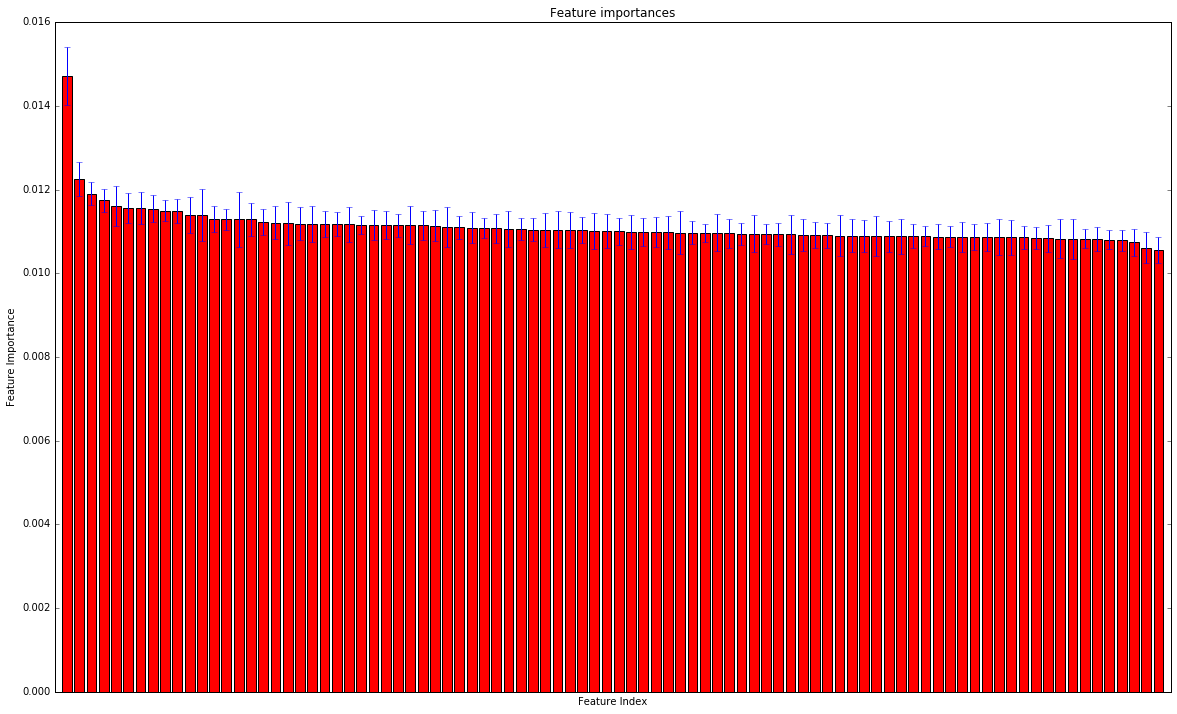

In [9]:
plot_importances(X,importances, indices,visible = False)

In [10]:
#SGD
def SGD(X, Y, X_test, Y_test):
    sgd = SGDRegressor(learning_rate=0.001, max_iter=200, batch_size=20)
    
    sgd.fit(X, Y)
    y_pred = sgd.predict(X_test)

    train_errors = deepcopy(sgd.getTrain_errors())
    plt.plot(range(0, len(train_errors)), np.log10(train_errors))
    plt.xlabel('Epochas')
    plt.ylabel('Cost')
    plt.title('Cost vs Iterations')

    plt.tight_layout()
    plt.show()
    sgd.getTrain_errors().clear()
    
    print("R@: %.2f "%r2_score(Y_test, y_pred))
    print("MSE %.2f "% mean_squared_error(Y_test, y_pred))
    print("RMSE %.2f "% np.sqrt(mean_squared_error(Y_test, y_pred)))
    

In [11]:
def SGD_cross_validation(X, Y, max_iter=100, batch_size=20, n_splits=5, learning_rate=0.0001):
    scores, best_model = cross_validation(X, Y, max_iter=max_iter, batch_size=batch_size, n_splits=n_splits, learning_rate=learning_rate)
    print("Error ", np.asarray(scores).mean())
    return best_model

In [12]:
def polymonial_regression(X, Y):
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    
    poly_features = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = poly_features.fit_transform(X_train)

    X_test_poly =  poly_features.fit_transform(X_test)
    
    sgd = SGDRegressor(learning_rate=0.001, max_iter=100, batch_size=20)
    sgd.fit(X_train_poly, Y_train)

    train_errors = deepcopy(sgd.getTrain_errors())
    
    plt.plot(range(0, len(train_errors)), np.log10(train_errors))
    plt.xlabel('Iteração')
    plt.ylabel('Custo')
    plt.title('Regressão Polinomial')

    plt.tight_layout()
    plt.show()
    sgd.getTrain_errors().clear()
    y_pred = sgd.predict(X_test_poly)
    
    print("R@: %.2f "%r2_score(Y_test, y_pred))
    print("MSE %.2f "% mean_squared_error(Y_test, y_pred))
    print("RMSE %.2f "% np.sqrt(mean_squared_error(Y_test, y_pred)))

In [13]:
#Baseline
SGD(X_train_scaled, Y_train, X_test_scaled, Y_test)

KeyboardInterrupt: 

In [14]:
#Cross validation
SGD_cross_validation(X_scaled, Y)

KeyboardInterrupt: 

In [15]:
#Normal equation with selection
X_train_n, X_test_n, Y_train_n, Y_test_n = train_test_split(X_tree, Y, test_size=0.2, random_state=0)
normal_equation(X_train_n, Y_train_n, X_test_n, Y_test_n)



R@: 0.20 
MSE 94.45 
RMSE 9.72 


In [16]:
#Normal equation
normal_equation(X_train_scaled, Y_train, X_test_scaled, Y_test)

R@: 0.23 
MSE 90.77 
RMSE 9.53 


In [17]:
#SGD with feature selection
SGD(X_train_n, Y_train_n, X_test_n, Y_test_n)

KeyboardInterrupt: 

In [ ]:
#Polynomial regression wiht PCA
x_pca_poly = pca(X_scaled, 0.95)
print(x_pca_poly.shape)
polymonial_regression(x_pca_poly, Y)

#Polynomial regression with Tree
polymonial_regression(X_tree, Y)

(111452, 67)


In [20]:
#Cross validation with PCA
best_model = SGD_cross_validation(X, Y, max_iter=200, batch_size=20)

KeyboardInterrupt: 

In [21]:
#Test !!!!!! Only one time !!!!!!!
data_test = load_data('year-prediction-msd-test.txt')

FileNotFoundError: File b'year-prediction-msd-test.txt' does not exist

In [58]:
data_test  = np.asarray(data_test)

In [80]:
Y_test_real = data_test[:,0]
X_test_real = data_test[:,1:]

X_real_scaled = scale(X_test_real)

In [81]:
Y_real_pred = best_model.predict(X_real_scaled)

In [82]:
print("R@: %.2f "%r2_score(Y_test_real, Y_real_pred))
print("MSE %.2f "% mean_squared_error(Y_test_real, Y_real_pred))
print("RMSE %.2f "% np.sqrt(mean_squared_error(Y_test_real, Y_real_pred)))

R@: -17162140360521171395936256.00 
MSE 2033817043235244068267098112.00 
RMSE 45097860739011.16 
